In [1]:
import os
import numpy as np

import SimpleITK as sitk
import matplotlib.pyplot as plt

In [2]:
segment_dir = r'./segment_img'
os.path.exists(segment_dir)

True

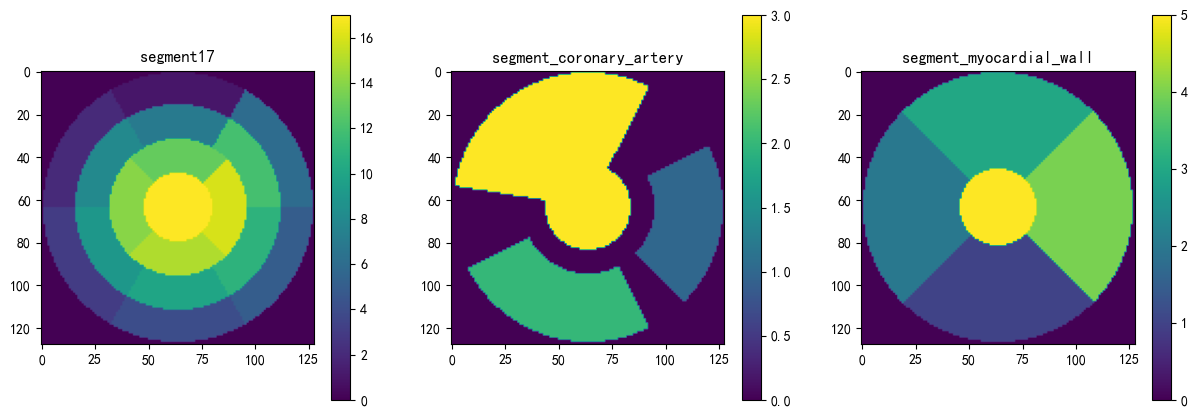

In [3]:
segment17 = np.load(os.path.join(segment_dir, 'segment17.npy')).astype(np.float32)
segment_coronary_artery = np.load(os.path.join(segment_dir, 'segment_coronary_artery.npy')).astype(np.float32)
segment_myocardial_wall = np.load(os.path.join(segment_dir, 'segment_myocardial_wall.npy')).astype(np.float32)

plt.figure(figsize=(15,5), dpi=100)
plt.subplot(131)
plt.title('segment17')
plt.imshow(segment17)
plt.colorbar()

plt.subplot(132)
plt.title('segment_coronary_artery')
plt.imshow(segment_coronary_artery)
plt.colorbar()

plt.subplot(133)
plt.title('segment_myocardial_wall')
plt.imshow(segment_myocardial_wall)
plt.colorbar()

In [4]:
# database refer to https://pmc.ncbi.nlm.nih.gov/articles/PMC5270769/#:~:text=The%20normal%20database%20is%20typically,study%20which%20is%20visually%20normal.
# Normal Databases for the Relative Quantification of Myocardial Perfusion
# Mathieu Rubeaux 1, Yuan Xu 1, Guido Germano 1,2, Daniel S Berman 1,2, Piotr J Slomka 1,2

# hypothesis: statistics calculated by mean±0.5*sd, normal limit is calculate by mean-2*sd, rest is fake!
scale = 0.8
normalized_AC_normal_limits_range_dict = {
    "male": {
        "rest":{
            "min": np.array([52,34,36,53,60,59,94,90,87,89,96,101,92,95,88,95,83])*scale,
            "max": np.array([61,37,42,61,67,69,101,100,95,97,100,103,95,103,95,102,86])*scale
        },
        "stress": {
            "min": np.array([52,34,36,53,60,59,94,90,87,89,96,101,92,95,88,95,83])*scale,
            "max": np.array([61,37,42,61,67,69,101,100,95,97,100,103,95,103,95,102,86])*scale
        }
        
    },
    "female": {
        "rest":{   
            "min": np.array([55,40,42,56,63,63,93,86,92,96,97,100,88,91,89,91,76])*scale,
            "max": np.array([66,41,44,65,68,73,100,98,97,103,100,103,91,99,98,100,85])*scale
        },
        "stress":{
            "min": np.array([55,40,42,56,63,63,93,86,92,96,97,100,88,91,89,91,76])*scale,
            "max": np.array([66,41,44,65,68,73,100,98,97,103,100,103,91,99,98,100,85])*scale
        },
    }
}

map_data = {}
# generate polor map range in paper
for gender,data_g in normalized_AC_normal_limits_range_dict.items():
    for status, data_s in data_g.items():
        for mx, data_mx in data_s.items():
            tmp = np.zeros_like(segment17)
            for idx, value in enumerate(data_mx, start=1):
                # print(idx, value)
                lb = segment17 == idx
                tmp[lb] = value
            map_data[f'{gender}_{status}_{mx}'] = tmp

normal_limits_dir = './normal_limits'
# calculate the sds and generate the normal limits
for gender in normalized_AC_normal_limits_range_dict.keys():
    for status in normalized_AC_normal_limits_range_dict[gender].keys():
        map_data[f'{gender}_{status}_sd'] = map_data[f'{gender}_{status}_max'] - map_data[f'{gender}_{status}_min']
        map_data[f'{gender}_{status}_normal_limits'] = map_data[f'{gender}_{status}_min'] - 3*map_data[f'{gender}_{status}_sd']
        np.save(os.path.join(normal_limits_dir, f'{gender}_{status}_normal_limits.npy'), map_data[f'{gender}_{status}_normal_limits'])
        np.save(os.path.join(normal_limits_dir, f'{gender}_{status}_sd.npy'), map_data[f'{gender}_{status}_sd'])


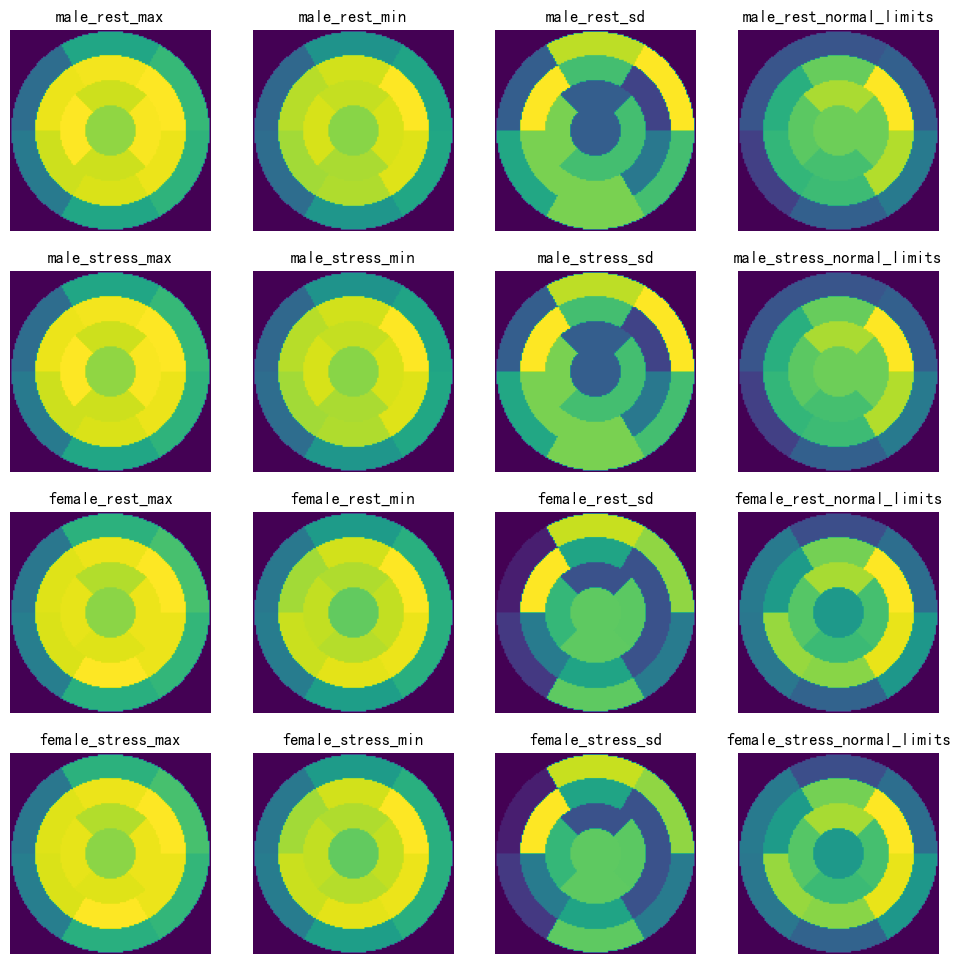

In [5]:
# plot
i = 0
fig, axes = plt.subplots(4, 4, figsize=(12, 12))  # Set your desired figure size here
for gender,data_g in normalized_AC_normal_limits_range_dict.items():
    for status,data_s in data_g.items():
        for fig_name in ['max', 'min', 'sd', 'normal_limits']:
            ax = axes.flat[i]
            img_name = f'{gender}_{status}_{fig_name}'
            im = ax.imshow(map_data[img_name])
            ax.set_title(img_name)
            ax.axis('off')
            i+=1

# plt.colorbar(im, ax=axes)

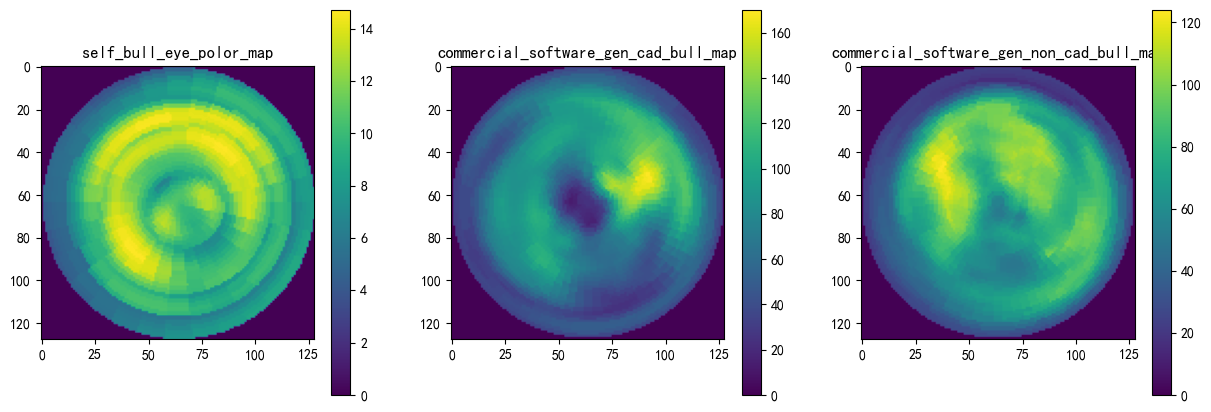

In [6]:
# visualise input image data
# self genernated bull eye and QTS-gen bull eye

perfusion_demo_img_dir = './perfusion_demo_img'
self_bull_eye_polor_map = np.load(os.path.join(perfusion_demo_img_dir, 'self_polor_map.npy'))
commercial_software_gen_cad_bull_map = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(perfusion_demo_img_dir, 'BullEye_cad'))).astype(np.float32)[-1]
commercial_software_gen_non_cad_bull_map = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(perfusion_demo_img_dir, 'BullEye'))).astype(np.float32)[-1]

plt.figure(figsize=(15,5), dpi=100)
plt.subplot(131)
plt.title('self_bull_eye_polor_map')
plt.imshow(self_bull_eye_polor_map)
plt.colorbar()

plt.subplot(132)
plt.title('commercial_software_gen_cad_bull_map')
plt.imshow(commercial_software_gen_cad_bull_map)
plt.colorbar()

plt.subplot(133)
plt.title('commercial_software_gen_non_cad_bull_map')
plt.imshow(commercial_software_gen_non_cad_bull_map)
plt.colorbar()